In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

### Importación del dataset

In [83]:
url='https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
df=pd.read_csv(url)

### Breve análisis exploratorio

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Se observa que la base de datos cuenta con 9 variables y 768 observaciones. Es de resaltar que no existen valores nulos. Al mismo tiempo, se observa que la variable 'Outcome' que es binaria debería ser categórica y es entera, por lo cual se procede a transformarla.

In [85]:
df['Outcome']=df['Outcome'].astype('category')

In [86]:
df.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
210,2,81,60,22,0,27.7,0.290,25,0
161,7,102,74,40,105,37.2,0.204,45,0
761,9,170,74,31,0,44.0,0.403,43,1
172,2,87,0,23,0,28.9,0.773,25,0
408,8,197,74,0,0,25.9,1.191,39,1
307,0,137,68,14,148,24.8,0.143,21,0
238,9,164,84,21,0,30.8,0.831,32,1
395,2,127,58,24,275,27.7,1.600,25,0
260,3,191,68,15,130,30.9,0.299,34,0
422,0,102,64,46,78,40.6,0.496,21,0


In [87]:
df.describe() # Variables numericas

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [88]:
df.describe(include='category') # Variable categórica

,Outcome
count,768
unique,2
top,0
freq,500


Existen algunos valores que llaman la atención, como es el minimo del nivel de glucosa en sangre y la presión sanguinea que alcanzan a ser nulas, así como el máximo de embarazos que alcanza los 17. Esto será objeto de análisis luego de dividir la base de datos en muestra de entrenamiento y prueba.

Como el problema que se intenta estimar es si una persona tiene diabetes, la variable objetivo será 'Outcome' y el modelo de ML a aplicar será Desition Tree. Dado que es un problema de clasificación, antes de realizar la partición entre entrenamiento y prueba se debe estudiar si la muestra original está balanceada.

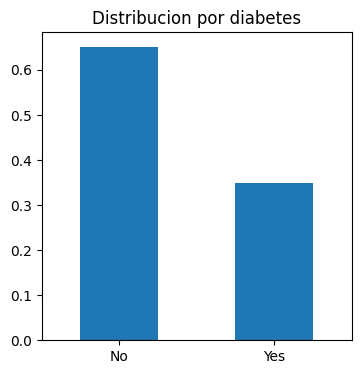

In [89]:
ax=df['Outcome'].value_counts(normalize=True).plot(kind='bar',title='Distribucion por diabetes',figsize=(4,4))
ax.set_xticklabels(['No','Yes'],rotation=360)
plt.show()

Se observa que no existe un desbalance significativo que deba contemplarse al plantear la selección de la muestra de entrenamiento. Sin embargo, se tendrá en cuenta como un posible hyperparámetro a testear al plantear el modelo de clasificación.

In [159]:
X=df.drop(columns='Outcome')
y=df['Outcome']

X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=1607)

In [161]:
#y_train.value_counts(normalize=True) 

In [162]:
df_train=pd.concat([X_train,y_train], axis=1)

In [163]:
df_train.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
200,0,113,80,16,0,31.0,0.874,21,0
692,2,121,70,32,95,39.1,0.886,23,0
499,6,154,74,32,193,29.3,0.839,39,0
568,4,154,72,29,126,31.3,0.338,37,0
229,0,117,80,31,53,45.2,0.089,24,0
674,8,91,82,0,0,35.6,0.587,68,0
207,5,162,104,0,0,37.7,0.151,52,1
598,1,173,74,0,0,36.8,0.088,38,1
261,3,141,0,0,0,30.0,0.761,27,1
676,9,156,86,0,0,24.8,0.230,53,1


A continuación se analiza la distribución de las variables por edad. 

Dado que las variables se comportan distinto según el rango, se decide dividir la edad en rangos e interpretar el resto de variables por rango etáreo.

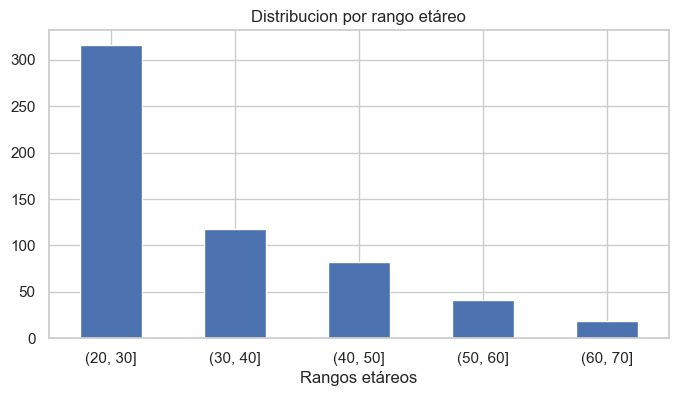

In [164]:
df_train['Age_rang']=pd.cut(df_train['Age'],bins=[20,30,40,50,60,70])
df_train['Age_rang']=df_train['Age_rang'].astype('category')
ax=df_train['Age_rang'].value_counts().plot(kind='bar',title='Distribucion por rango etáreo',figsize=(8,4),xlabel='Rangos etáreos')
ax.set_xticklabels(labels=df_train['Age_rang'].value_counts().index,rotation=360)
plt.show()

In [194]:
# Se aplica la transformacion al set de prueba que se utillizara luego para testear el modelo
X_test['Age_rang']=pd.cut(X_test['Age'],bins=[20,30,40,50,60,70])
X_test['Age_rang']=X_test['Age_rang'].astype('category')

**Distribución de variables por rango etáreo**

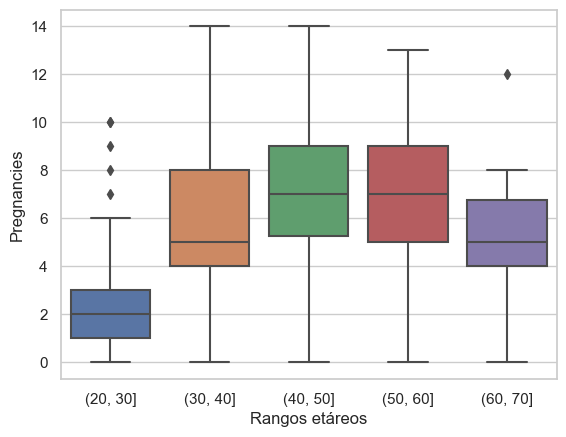

In [165]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y=df_train['Pregnancies'], x=df_train['Age_rang'])
ax.set_xlabel('Rangos etáreos')
plt.show()

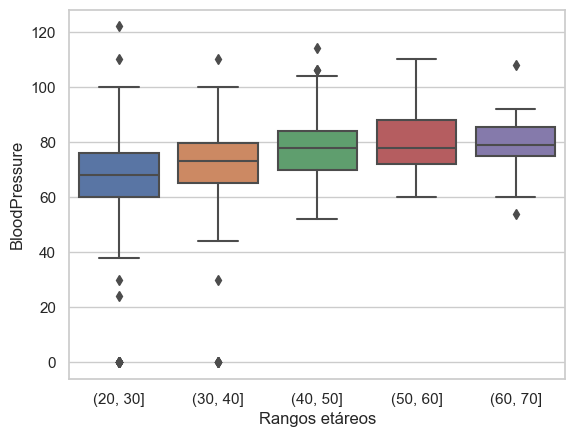

In [149]:
ax = sns.boxplot(y=df_train['BloodPressure'], x=df_train['Age_rang'])
ax.set_xlabel('Rangos etáreos')
plt.show()

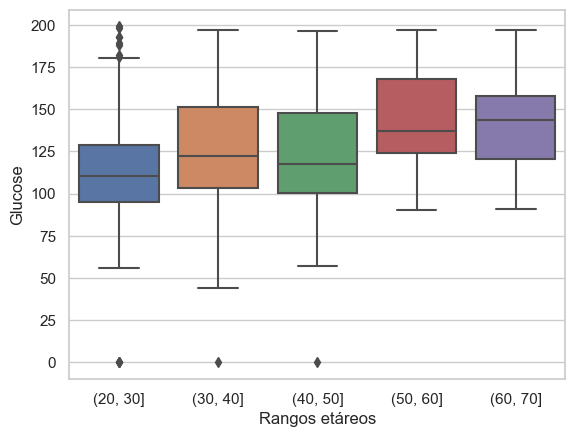

In [150]:
ax = sns.boxplot(y=df_train['Glucose'], x=df_train['Age_rang'])
ax.set_xlabel('Rangos etáreos')
plt.show()


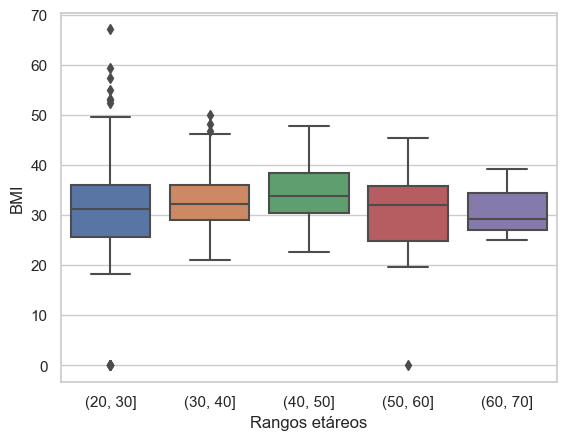

In [151]:
ax = sns.boxplot(y=df_train['BMI'], x=df_train['Age_rang'])
ax.set_xlabel('Rangos etáreos')
plt.show()

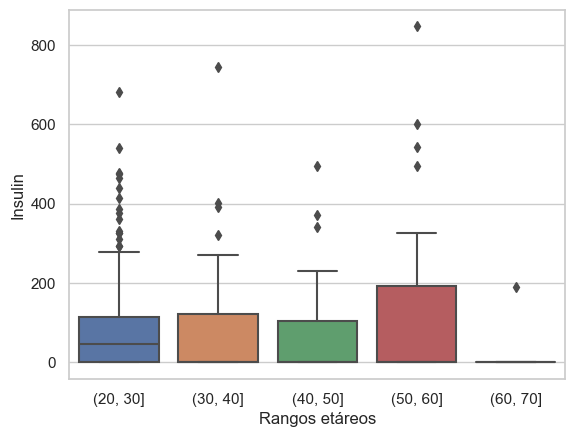

In [152]:
ax = sns.boxplot(y=df_train['Insulin'], x=df_train['Age_rang'])
ax.set_xlabel('Rangos etáreos')
plt.show()

Conclusiones del análisis por rango etáreo:
- Embarazos: existen algunos valores atípicos para el primer y último rango de edad. Considerando que la gran cantidad de embarazos a edades tempranas pueden estar relacionados a patrones adquiridos por las clases sociales bajas, se decide considerarlos y no eliminar dichas observaciones por creer que no se originan en un error en el ingreso de los datos. Al mismo tiempo, el valor atípico del rango más alto no es tan fuera de lo normal si se considera que años atrás las mujeres no estaban tan incertadas en el mercado laboral y tenían más hijos.
- Presión en sangre, glucosa e BMI: se detectan valores nulos que deberán ser tratados, así como valores atípicos que no parecerían ser ireales, a no ser en el caso de BMI donde los valores por encima de 60 para el primer rango de edad parecerían ser un error.
- Insulina en sangre: existencia de gran cantidad de valores atípicos, principalmente llaman la atención aquellos que superan los 400 mu U/ml.

Como resultado del análisis anterior se dedice:
- Imputar los valores nulos con la media de cada variable BMI, BloodPressure y Glucose
- Imputar los valores atípicos superiores a 400 con la media en la variable Insulin

In [166]:
for i in ['BMI','BloodPressure','Glucose']:
    df_train=df_train.replace({i:0}, df_train[i].mean()) 

In [167]:
df_train['Insulin'].mask(df_train['Insulin']>400,df_train['Insulin'].mean(),inplace=True)

### Selección de features

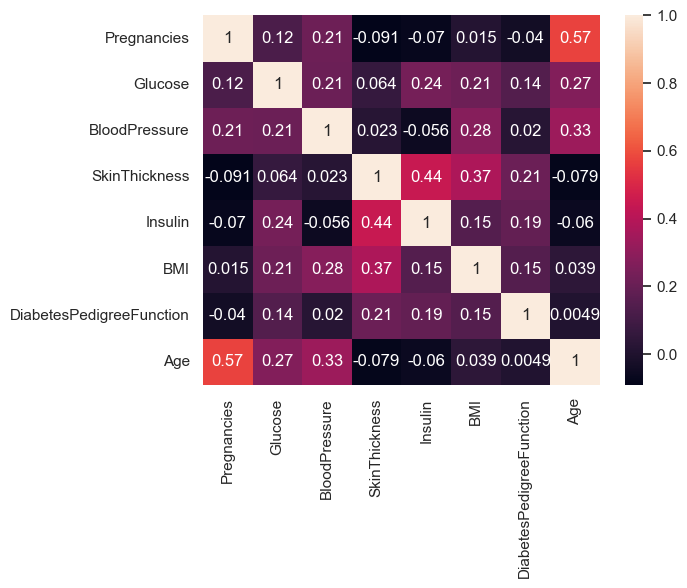

In [168]:
sns.heatmap(df_train.corr(),annot=True)
plt.show()

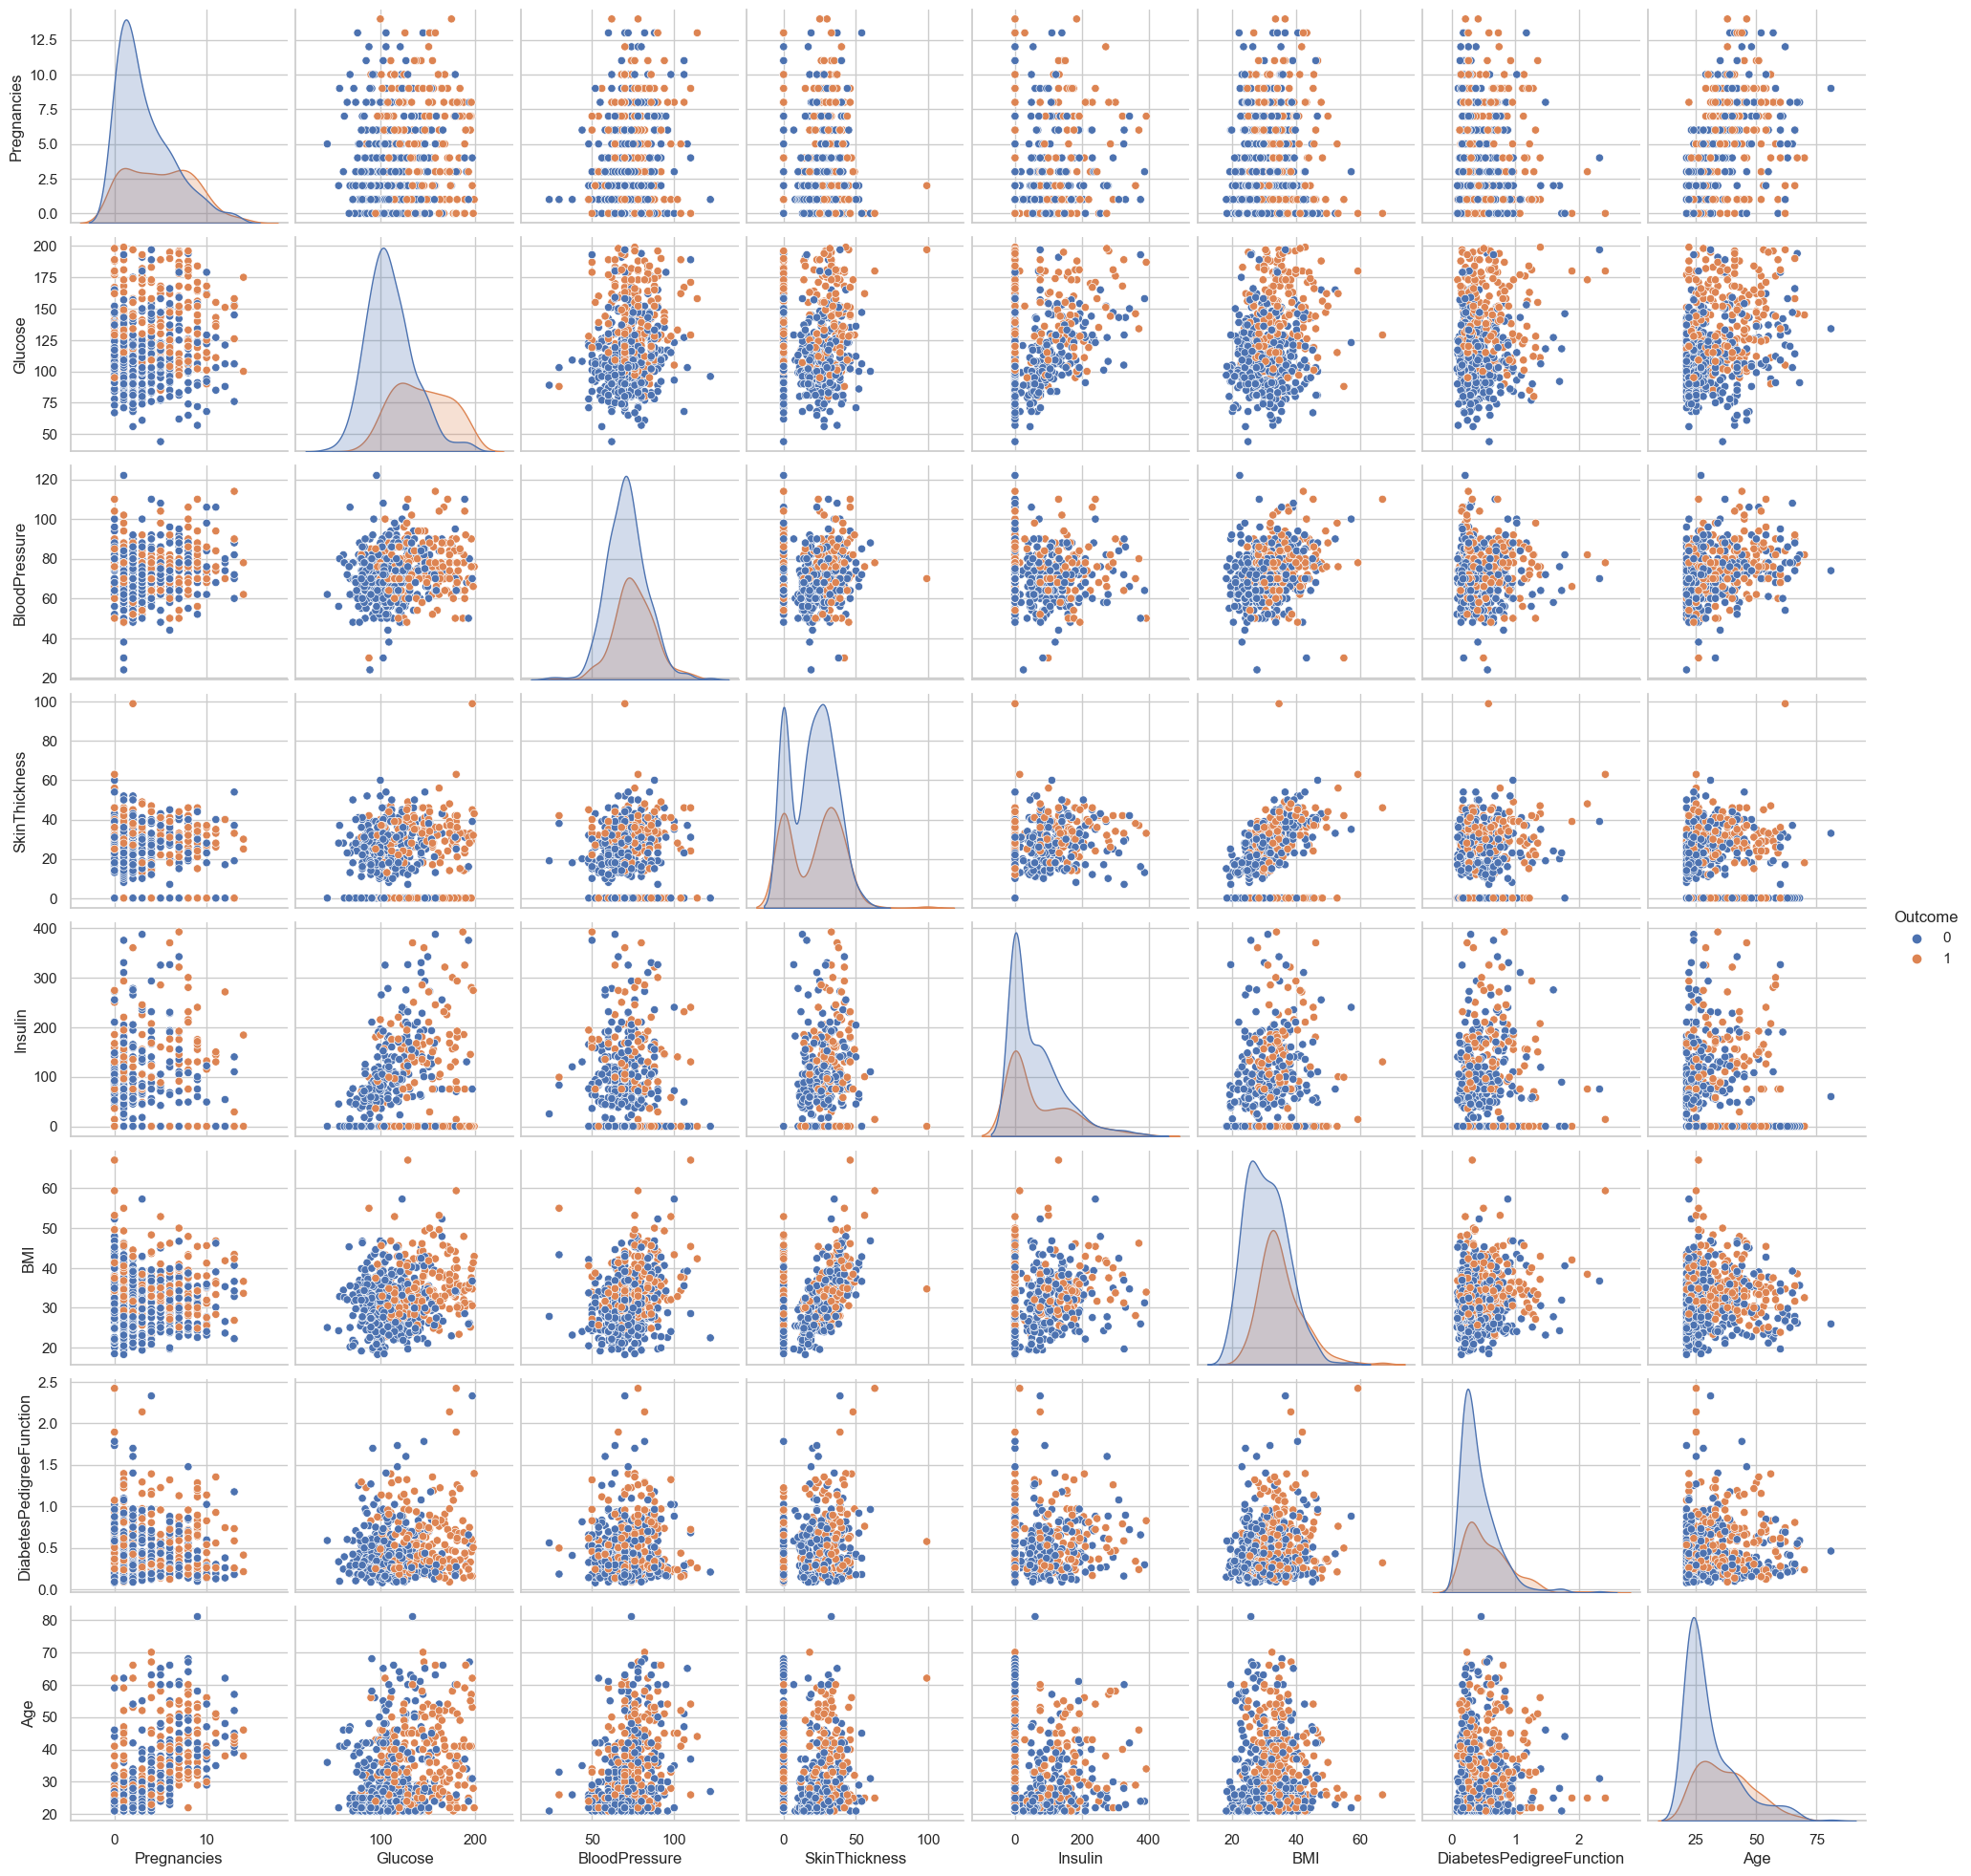

In [169]:
sns.pairplot(df_train,hue='Outcome')
plt.show()

En primer lugar no se observan señales de multicolinealidad entre variables explicativas, el valor más alto de correlación que se observa es 0,57. En segundo lugar no se observa una relación directa entre la variable dependiente y las explicativas que a simple vista lleve a pensar que ciertos valores de las variables están relacionados directamente con la diabetes.Quizás en con respecto a la glucosa es en el único caso donde parecería distinguirse dos grupos.

Luego de estudiar la correlación, se decide considerar todas las variables como explicativas para el modelo de clasificación.

**Encoding**

In [195]:
df_train['Age_rang_cod']=df_train['Age_rang'].cat.codes
X_test['Age_rang_cod']=X_test['Age_rang'].cat.codes

In [180]:
df_train.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_rang,Age_rang_cod
681,0,162.0,76.0,36,0.0,49.6,0.364,26,1,"(20, 30]",0
354,3,90.0,78.0,0,0.0,42.7,0.559,21,0,"(20, 30]",0
583,8,100.0,76.0,0,0.0,38.7,0.190,42,0,"(40, 50]",2
100,1,163.0,72.0,0,0.0,39.0,1.222,33,1,"(30, 40]",1
608,0,152.0,82.0,39,272.0,41.5,0.270,27,0,"(20, 30]",0
148,5,147.0,78.0,0,0.0,33.7,0.218,65,0,"(60, 70]",4
501,3,84.0,72.0,32,0.0,37.2,0.267,28,0,"(20, 30]",0
405,2,123.0,48.0,32,165.0,42.1,0.520,26,0,"(20, 30]",0
677,0,93.0,60.0,0,0.0,35.3,0.263,25,0,"(20, 30]",0
192,7,159.0,66.0,0,0.0,30.4,0.383,36,1,"(30, 40]",1


Nota: no se escalan las variables numéricas, dado que se entiende que en éstos modelos que no trabajan con distancias, no incide la escala.

In [197]:
X_train=df_train.drop(columns=['Outcome','Age','Age_rang'])
X_test=X_test.drop(columns=['Age','Age_rang'])
y_train=df_train['Outcome']

In [189]:
X_train.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age_rang_cod
682,0,95.0,64.0,39,105.000000,44.6,0.366,0
367,0,101.0,64.0,17,0.000000,21.0,0.252,0
523,9,130.0,70.0,0,0.000000,34.2,0.652,2
35,4,103.0,60.0,33,192.000000,24.0,0.966,1
220,0,177.0,60.0,29,75.088542,34.6,1.072,0


In [190]:
y_train.sample(5)

220    1
57     0
58     0
298    1
18     0
Name: Outcome, dtype: category
Categories (2, int64): [0, 1]

In [198]:
X_test.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age_rang_cod
284,2,108,80,0,0,27.0,0.259,3
328,2,102,86,36,120,45.5,0.127,0
380,1,107,72,30,82,30.8,0.821,0
448,0,104,64,37,64,33.6,0.510,0
14,5,166,72,19,175,25.8,0.587,3


### Decision Tree Classifier

In [191]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=0)

In [192]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [206]:
print(f'R^2 score:{clf.score(X_train,y_train)}')

R^2 score:1.0


Como era de esperar el modelo sobreajusto con la muestra de entrenamiento.

In [205]:
#plt.figure(figsize=(10,8))
#tree.plot_tree(clf)
#plt.show()

In [199]:
clf_pred=clf.predict(X_test)

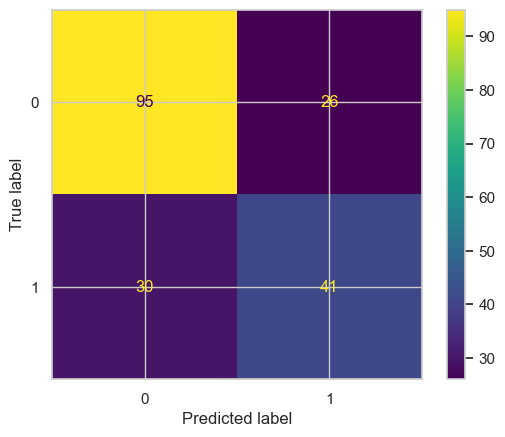

In [200]:
cm = confusion_matrix(y_test, clf_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=clf.classes_)
disp.plot()

plt.show()

In [201]:
print(classification_report(y_test,clf_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       121
           1       0.61      0.58      0.59        71

    accuracy                           0.71       192
   macro avg       0.69      0.68      0.68       192
weighted avg       0.71      0.71      0.71       192



Cuando se testea con nuevas observaciones, el modelo no tiene muy buen ajuste. Se observa que el recall es del 58% para la clase minoritaria indicando que no es un buen modelo para predecir los casos criticos, que en este caso son los positivos de diabetes.

**Fiting hyperparameters**

In [214]:
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#Criterion for measure the quality of a split
criterion=['gini','entropy']
# class weight for unbalanced samples
weight=['balanced', None]
# Create the random grid
params = {#'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'criterion':criterion,
'class_weight':weight}
print(params)

{'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None]}


In [215]:
grid_clasif = GridSearchCV(clf,params, verbose=1, cv=5)

In [216]:
%%time
grid_clasif.fit(X_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Wall time: 6.34 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=0),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 35, 60, 85, 110, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=1)

In [217]:
grid_clasif.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=35, min_samples_leaf=2,
                       min_samples_split=5, random_state=0)

In [221]:
print('The best model has the parameters:',grid_clasif.best_estimator_.get_params())

The best model has the parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 35, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


In [222]:
best_classif=DecisionTreeClassifier(**grid_clasif.best_estimator_.get_params())

In [223]:
best_classif.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=35, min_samples_leaf=2,
                       min_samples_split=5, random_state=0)

In [224]:
print(f'R^2 score:{best_classif.score(X_train,y_train)}')

R^2 score:0.9548611111111112


In [227]:
y_pred_best=best_classif.predict(X_test)

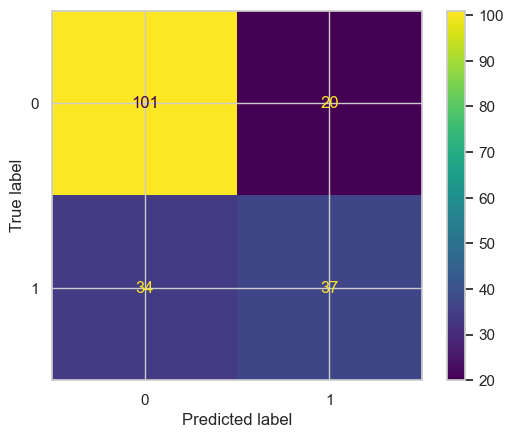

In [229]:
cm = confusion_matrix(y_test, y_pred_best, labels=best_classif.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=best_classif.classes_)
disp.plot()

plt.show()

In [230]:
print(classification_report(y_test,y_pred_best))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       121
           1       0.65      0.52      0.58        71

    accuracy                           0.72       192
   macro avg       0.70      0.68      0.68       192
weighted avg       0.71      0.72      0.71       192



No se observa una mejora en el ajuste luego de realizar el tuneado de los hiperparámetros.

https://medium.com/analytics-vidhya/decisiontree-classifier-working-on-moons-dataset-using-gridsearchcv-to-find-best-hyperparameters-ede24a06b489#:~:text=Save-,DecisionTree%20Classifier%20%E2%80%94%20Working%20on%20Moons%20Dataset%20using%20GridSearchCV%20to%20find,logic%20behind%20decision%20tree's%20classification.